In [1]:
%load_ext autoreload
%autoreload 2

# Simple representation space tests with an FCN


## Imports


In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from typing import List
from functools import partial

import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score  
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

I0000 00:00:1698425699.665153  698199 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

In [3]:
sys.path

['/home/wadh6511/Kode/EvoScaper/notebooks',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages',
 '/home/wadh6511/Kode/env_evo/src/bioreaction/src',
 '/home/wadh6511/Kode/EvoScaper']

In [4]:
from src.models.mlp import MLP, MLP_fn
from src.losses.losses import loss_fn, compute_accuracy_categorical, compute_accuracy_regression

In [5]:
# Make sure GPU is actually working
jnp.arange(9)

Array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

## Load data


In [6]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

## Hyperparameters


In [7]:
BATCH_SIZE = 128
N_BATCHES = 500
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
train_split_perc = 0.8
TRAIN_SPLIT = int(train_split_perc * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1000
PRINT_EVERY = EPOCHS // 30
SEED = 1
INPUT_SPECIES = 'RNA_1'
target_circ_func = 'sensitivity_wrt_species-6'
input_concat_diffs = True
input_concat_axis = 0
output_options = ['std', 'ratio', 'log_ratio', 'abs_1_log_ratio']
output_option = output_options[2]

# MLP Architecture
LAYER_SIZES = [64, 64, 64]
USE_CATEGORICAL = False
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='categorical' if USE_CATEGORICAL else 'mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_categorical if USE_CATEGORICAL else compute_accuracy_regression

subtask = 'dual_' + output_option + '_' + str(input_concat_diffs) + str(input_concat_axis) + '_'
save_path = 'saves_' + subtask + str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_')

rng = jax.random.PRNGKey(SEED)

## Initialise


### Input

To make sure that there is little repetition in the dataset, the uniqueness of each sample will be judged. For genetic circuits,there is a lot of sparsity, as most biological sequences do not interact. Therefore, there may be an overrepresentation of some circuit topologies.


In [8]:
def custom_round(x, base=5):
    return base * round(x/base)


def convert_to_scientific_exponent(x, numerical_resolution: dict):
    exp_not = f'{x:.0e}'.split('e')
    resolution = numerical_resolution[int(exp_not[1])]
    base = int(10 / resolution)
    pre = custom_round(int(exp_not[0]), base=base)
    return int(exp_not[1]) + pre / 10


def drop_duplicates_keep_first_n(df, column, n):
    """ GCG """
    indices = df[df.duplicated(subset=column, keep=False)].groupby(
        column).head(n).index
    all_duplicates_indices = df[df.duplicated(subset=column, keep=False)].index
    to_drop = list(set(all_duplicates_indices) - set(indices))
    df2 = df.drop(to_drop)
    return df2


vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES
numerical_resolution = 2


# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=200)
k = 'energies'
df[[f'{i}_diffs' for i in get_true_interaction_cols(data, k, remove_symmetrical=True)]] = df.groupby(
    ['circuit_name'])[get_true_interaction_cols(data, k, remove_symmetrical=True)].apply(lambda x: x - x.iloc[0]).to_numpy()


['std', 'ratio', 'log_ratio', 'abs_1_log_ratio']
dual_suffix = ''
if output_option == 'std':
    dual_suffix = '_std'
    grouped_std = df.groupby(by=['circuit_name', 'mutation_num'])[
        target_circ_func].std().reset_index()
    df = pd.merge(df, grouped_std, on=[
                  'circuit_name', 'mutation_num'], suffixes=('', dual_suffix))
elif output_option == 'ratio':
    dual_suffix = '_ratio_from_mutation_to_base'
elif output_option == 'log_ratio':
    dual_suffix = '_log_ratio'
    df[target_circ_func + dual_suffix] = np.where(df[target_circ_func + '_ratio_from_mutation_to_base']
                                                  == 0, -10, np.log10(df[target_circ_func + '_ratio_from_mutation_to_base']))
elif output_option == 'abs_1_log_ratio':
    dual_suffix = '_abs_log_ratio'
    df[target_circ_func + dual_suffix] = np.abs(np.log10(1 - df[target_circ_func + '_ratio_from_mutation_to_base']))

df[target_circ_func] = df[target_circ_func].round(
    np.abs(int(f'{df[target_circ_func].min():.0e}'.split('e')[1]))-1)
df[target_circ_func + dual_suffix] = df[target_circ_func + dual_suffix].round(
    np.abs(int(f'{df[target_circ_func + dual_suffix].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(
    df, column=target_circ_func, n=200)


TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])

In [9]:
TOTAL_DS

64000

In [10]:
x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]
if input_concat_diffs:
    x_cols = x_cols + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, k, remove_symmetrical=True)]]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1)

y_cols = [target_circ_func,
          target_circ_func + dual_suffix]
y = df[y_cols].iloc[:TOTAL_DS].to_numpy()


if USE_CATEGORICAL:
    y_map = {k: numerical_resolution for k in np.arange(int(f'{y[y != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{y.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    y_map[-6] = 1
    y_map[-5] = 1
    y_map[-4] = 4
    y_map[-3] = 2
    y_map[-1] = 3
    y = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=y_map), y)
    y = np.interp(y, sorted(np.unique(y)), np.arange(
        len(sorted(np.unique(y))))).astype(int)
else:
    zero_log_replacement = -10.0
    y = np.where(y != 0, np.log10(y), zero_log_replacement)

# Make sure there are no nans
x = x[np.sum(np.isnan(y), axis=1) == 0]
y = y[np.sum(np.isnan(y), axis=1) == 0]

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = len(np.unique(y)) if USE_CATEGORICAL else len(y_cols)


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

/tmp/ipykernel_698199/1314598869.py:29: RuntimeWarning: divide by zero encountered in log10
  y = np.where(y != 0, np.log10(y), zero_log_replacement)


#### Scale input


In [11]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
og_x_shape = x.shape
x = xscaler.fit_transform(x.reshape(og_x_shape[0], np.prod(og_x_shape[1:]))).reshape(og_x_shape).squeeze()
# y = yscaler.fit_transform(y)
# inverse = xscaler.inverse_transform(normalized)

# xscaler, yscaler = StandardScaler(), StandardScaler()
# x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = scaler.inverse_transform(standardized)

In [12]:
x.shape

(64000, 12)

In [13]:
x_train, y_train = x[:TRAIN_SPLIT], y[:TRAIN_SPLIT]
x_val, y_val = x[-TEST_SPLIT:], y[-TEST_SPLIT:]

Text(0.5, 1.0, 'y 1: Sensitivity with respect to species-6 log ratio')

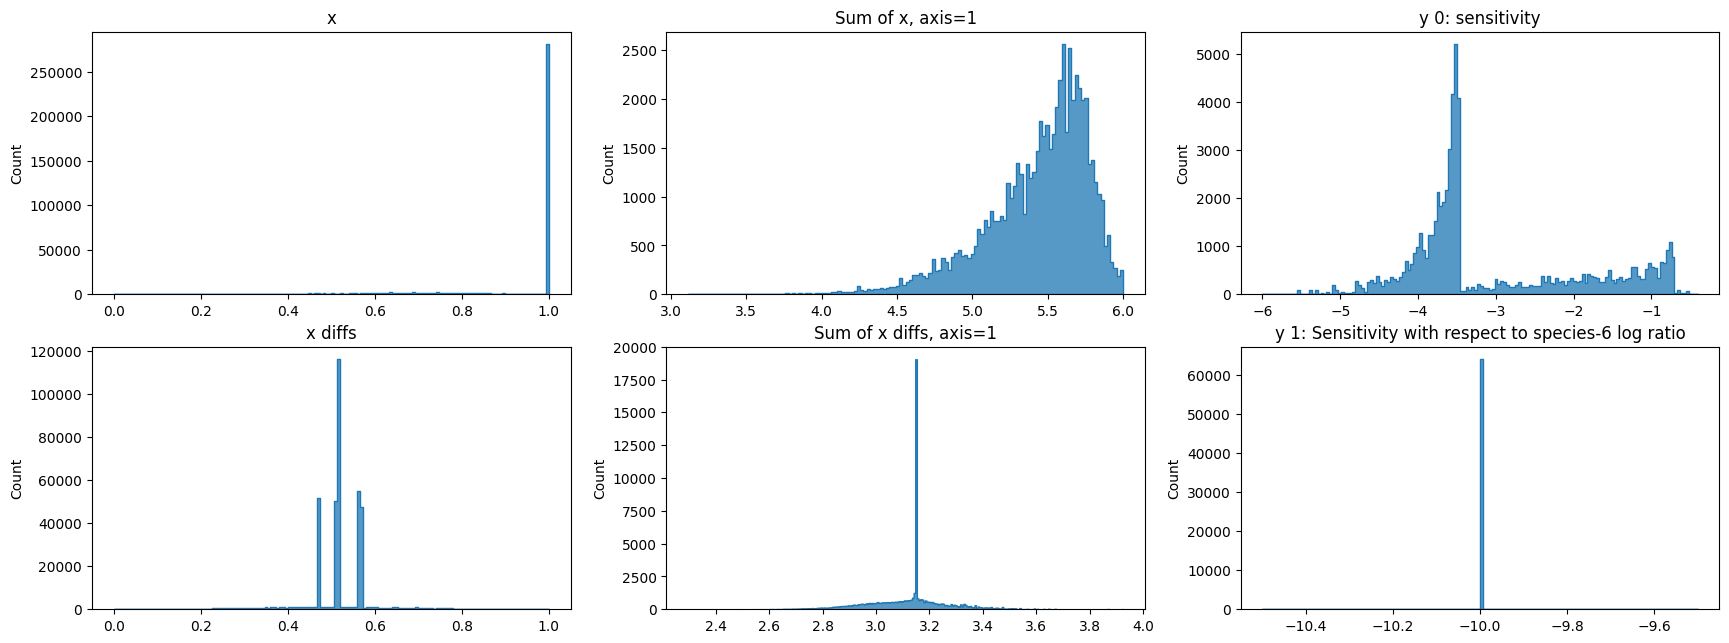

In [14]:
plt.figure(figsize=(3*7, 5 * 1.5))
ax = plt.subplot(2, 3, 1)
sns.histplot(x=x[:, :6].flatten(), element='step', bins=150)
plt.title('x')
ax = plt.subplot(2, 3, 2)
sns.histplot(x=np.sum(x[:, :6], axis=1).flatten(), element='step')
plt.title('Sum of x, axis=1')
ax = plt.subplot(2, 3, 3)
sns.histplot(x=(y[:, 0].flatten()), element='step', bins=150)
plt.title('y 0: sensitivity')

ax = plt.subplot(2, 3, 4)
sns.histplot(x=x[:, 6:].flatten(), element='step', bins=150, log_scale=[False, False])
plt.title('x diffs')
ax = plt.subplot(2, 3, 5)
sns.histplot(x=np.sum(x[:, 6:], axis=1).flatten(), element='step', log_scale=[False, False])
plt.title('Sum of x diffs, axis=1')
ax = plt.subplot(2, 3, 6)
sns.histplot(x=(y[:, 1].flatten()), element='step', bins=150, log_scale=[False, False])
plt.title(f'y 1: {prettify_keys_for_label(target_circ_func + dual_suffix)}') 

Text(0.5, 1.0, 'y')

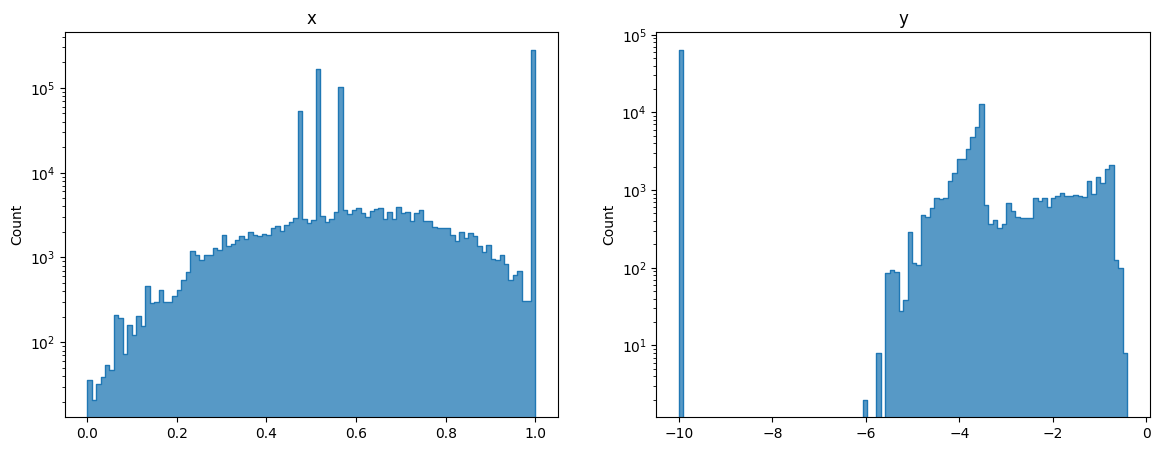

In [15]:
plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(x=x.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('x')
ax = plt.subplot(1, 2, 2)
sns.histplot(x=y.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('y')

### Initialise WandB 


In [16]:

wandb.init(
    # set the wandb project where this run will be logged
    project="mlp-encoder_decoder",
    # track hyperparameters and run metadata
    config={
        "architecture": "MLP_dual",
        "dataset": "Circuits",
        "epochs": EPOCHS,
        "input_species": INPUT_SPECIES,
        "input_concat_diffs": input_concat_diffs,
        "input_concat_axis": input_concat_axis,
        "layer_sizes": LAYER_SIZES,
        "learning_rate": LEARNING_RATE,
        "learning_rate_schedule": LEARNING_RATE_SCHED,
        "n_head": N_HEAD,
        "output_option": output_option,
        "seed": SEED,
        "target_circuit_function": target_circ_func,
        "total_dataset_size": TOTAL_DS,
        "train_split_percentage": train_split_perc,
        "use_categorical": USE_CATEGORICAL,
        "use_dropout": USE_DROPOUT,
        "use_L2_reg": USE_L2_REG,
        "use_warmup": USE_WARMUP,
        "warmup_epochs": WARMUP_EPOCHS
    }
)

wandb: Currently logged in as: olivia-gallup (steel-lab). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /home/wadh6511/Kode/EvoScaper/notebooks/wandb/run-20231027_175514-toc0r1qc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run helpful-elevator-48
wandb: ⭐️ View project at https://wandb.ai/steel-lab/mlp-encoder_decoder
wandb: 🚀 View run at https://wandb.ai/steel-lab/mlp-encoder_decoder/runs/toc0r1qc


### Initialise model


In [17]:
model = hk.transform(partial(MLP_fn, init_kwargs={
                     'layer_sizes': LAYER_SIZES, 'n_head': N_HEAD, 'use_categorical': USE_CATEGORICAL}))

params = model.init(rng, x[:2])

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Optimiser


In [18]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(
        LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE
optimiser = optax.sgd(learning_rate=learning_rate_scheduler)

if USE_WARMUP:
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=LEARNING_RATE,
        transition_steps=WARMUP_EPOCHS * N_BATCHES)
    cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=LEARNING_RATE,
        decay_steps=cosine_epochs * N_BATCHES)
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[WARMUP_EPOCHS * N_BATCHES])
    optimiser = optax.sgd(learning_rate=schedule_fn)

optimiser_state = optimiser.init(x)

## Train


In [19]:
def train_step(params, rng, model, x, y, optimiser, optimiser_state, l2_reg_alpha):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, loss, grads


def eval_step(params, rng, model: MLP, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss


def train(params, rng, model, x_train, y_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs, batch_size: int,
          save_every: int = 50):
    saves = {}
    n_batches = (x_train.shape[0]//batch_size)+1
    for e in range(epochs):

        for batch in range(n_batches):
            start = int(batch*batch_size)
            end = int((batch+1)*batch_size) if batch != n_batches - 1 else None

            # Single batch of data
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            if len(x_batch) and len(y_batch):
                params, train_loss, grads = train_step(
                    params, rng, model, x_batch, y_batch, optimiser, optimiser_state, l2_reg_alpha)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')
            
    return params, saves

In [20]:
params, saves = train(params, rng, model, x_train, y_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      save_every=PRINT_EVERY)  # int(STEPS // 15))

Epoch 0 / 1000 -		 Train loss: 0.6607834696769714	Val loss: 0.6501035690307617	Val accuracy: 0.28886717557907104
Epoch 33 / 1000 -		 Train loss: 0.09608611464500427	Val loss: 0.0899004116654396	Val accuracy: 0.5028905868530273
Epoch 66 / 1000 -		 Train loss: 0.06529049575328827	Val loss: 0.05038866028189659	Val accuracy: 0.6476171612739563
Epoch 99 / 1000 -		 Train loss: 0.06174899637699127	Val loss: 0.04507556930184364	Val accuracy: 0.6767968535423279
Epoch 132 / 1000 -		 Train loss: 0.05883919820189476	Val loss: 0.04234199598431587	Val accuracy: 0.6936718821525574
Epoch 165 / 1000 -		 Train loss: 0.0563395693898201	Val loss: 0.04036840423941612	Val accuracy: 0.7026562094688416
Epoch 198 / 1000 -		 Train loss: 0.05412803962826729	Val loss: 0.038710158318281174	Val accuracy: 0.7145702838897705
Epoch 231 / 1000 -		 Train loss: 0.05233757197856903	Val loss: 0.03732934966683388	Val accuracy: 0.720507800579071
Epoch 264 / 1000 -		 Train loss: 0.050795942544937134	Val loss: 0.03615275397896

## Visualise


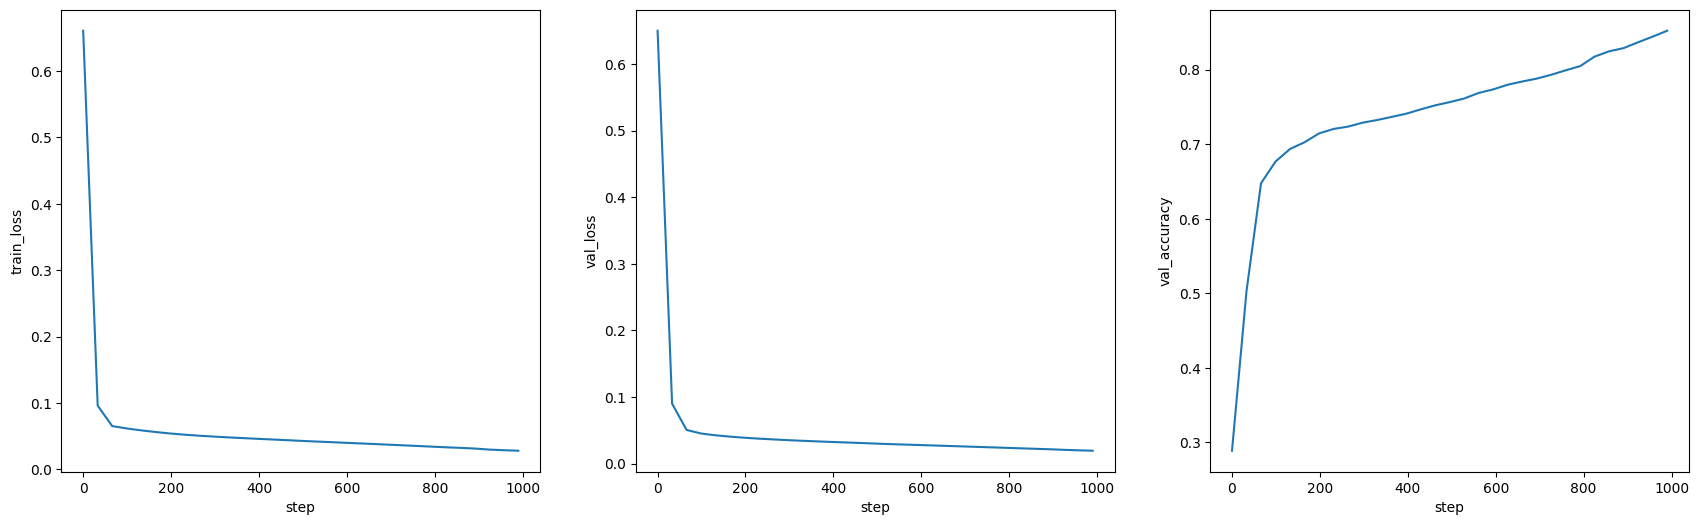

In [21]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.savefig('training_summary.png')

The R2 score is  0.4861486646557907
The R2 score with weighted variance is  0.9722973293115815


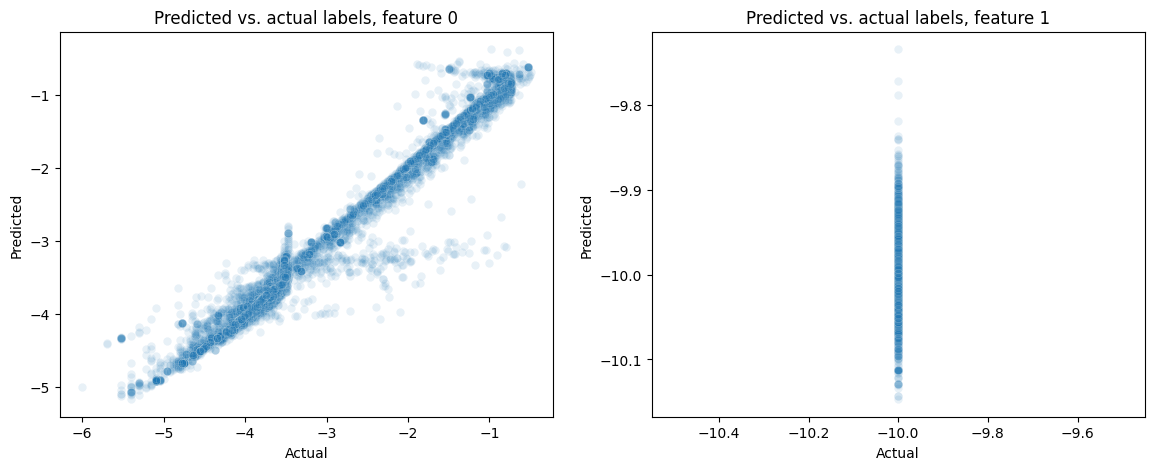

In [22]:
# params = arrayise(params)
predicted = model.apply(params, rng, x_val)
if USE_CATEGORICAL:
    predicted = jnp.argmax(predicted, axis=1)

plt.figure(figsize=(7*y_val.shape[-1], 5))
for i in range(y_val.shape[-1]):
    ax = plt.subplot(1, y_val.shape[-1], i+1)
    sns.scatterplot(x=y_val[:, i], y=predicted[:, i], alpha=0.1)
    plt.title(f'Predicted vs. actual labels, feature {i}')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')

print('The R2 score is ', r2_score(y_val, predicted))
print('The R2 score with weighted variance is ', r2_score(
    y_val, predicted, multioutput='variance_weighted'))

Text(0.5, 0.98, 'Param weights: FCN/~create_layers/linear_2')

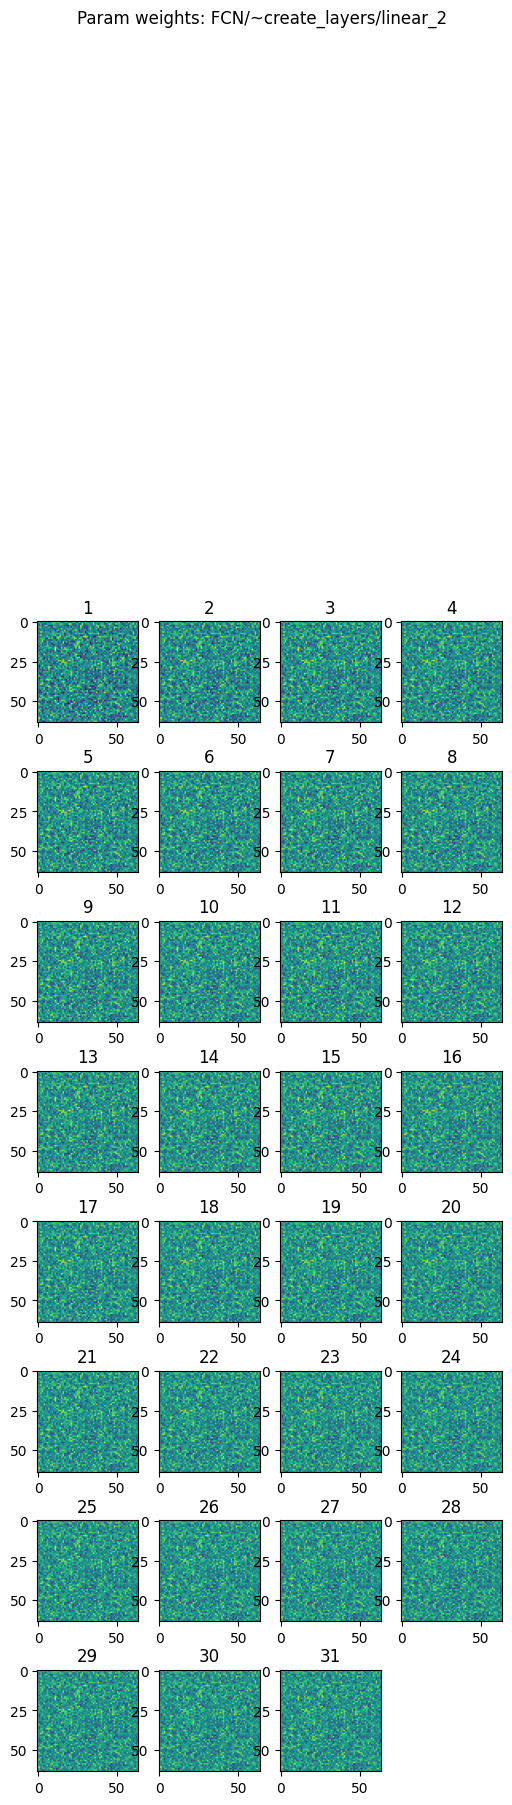

In [23]:
saves_params = [v['params'] for v in saves.values()]

plt.figure(figsize=(6*1, 10*6))
i = 1
layer_to_visualise = list(saves_params[0].keys())[2]
for s in saves_params:
    for v in [s[layer_to_visualise]]:
        ax = plt.subplot(len(saves_params), 4, i)
        plt.imshow(v['w'])
        plt.title(i)
        i += 1
plt.suptitle(f'Param weights: {layer_to_visualise}')

In [24]:
write_json(saves, out_path=save_path)

## Examine trained model


In [25]:
# saves_loaded = load_json_as_dict('saves')
# saves_loaded = load_json_as_dict('saves_20231016')
# saves_loaded = load_json_as_dict('saves_20231019')
saves_loaded = load_json_as_dict(save_path)


def arrayise(d):
    for k, v in d.items():
        if type(v) == dict:
            for kk, vv in v.items():
                d[k][kk] = jnp.array(vv)
    return d


step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

pred_y = model.apply(p, rng, x)
if USE_CATEGORICAL:
    pred_y = jnp.argmax(pred_y, axis=1)
saves_loaded.keys()

dict_keys(['0', '33', '66', '99', '132', '165', '198', '231', '264', '297', '330', '363', '396', '429', '462', '495', '528', '561', '594', '627', '660', '693', '726', '759', '792', '825', '858', '891', '924', '957', '990'])

The R2 score is  0.48534643068251704
The R2 score with weighted variance is  0.9706928613650341


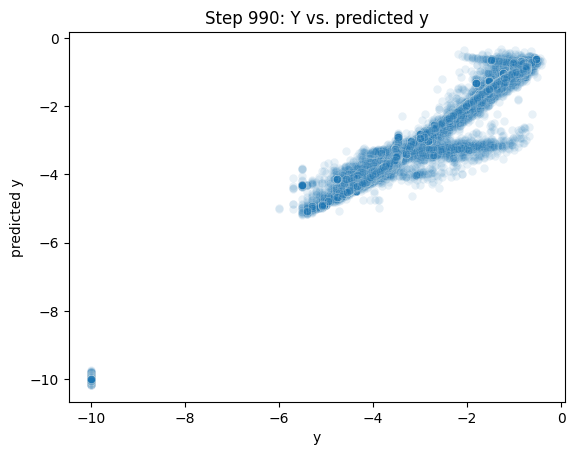

In [26]:
sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
plt.title(f'Step {step}: Y vs. predicted y')
plt.xlabel('y')
plt.ylabel('predicted y')

print('The R2 score is ', r2_score(y, pred_y))
print('The R2 score with weighted variance is ', r2_score(
    y, pred_y, multioutput='variance_weighted'))

In [27]:


# rows = int(np.ceil(np.sqrt(len(saves_loaded))))
# cols = int(np.ceil(np.sqrt(len(saves_loaded))))

# fig = plt.figure(figsize=(7*cols, 6*rows))
# for i, (step, v) in enumerate(saves_loaded.items()):
#     p = v['params']
#     p = arrayise(p)

#     pred_y = model.apply(p, rng, x)

#     ax = plt.subplot(rows, cols, i+1)
#     sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
#     plt.title(f'Step {step}: Y vs. predicted y')
#     plt.xlabel('y')
#     plt.ylabel('predicted y')

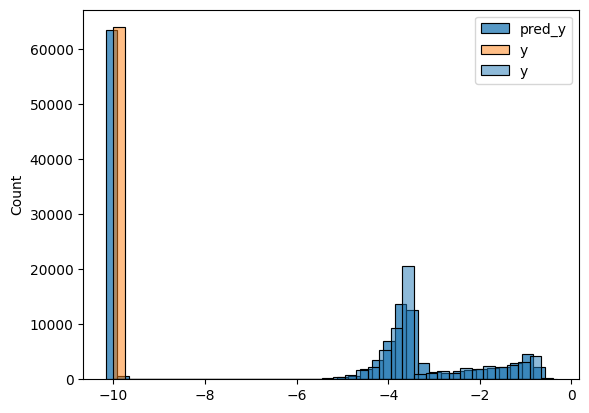

In [28]:

sns.histplot(pred_y.flatten(), label='pred_y')
sns.histplot(y, label='y')
plt.legend()

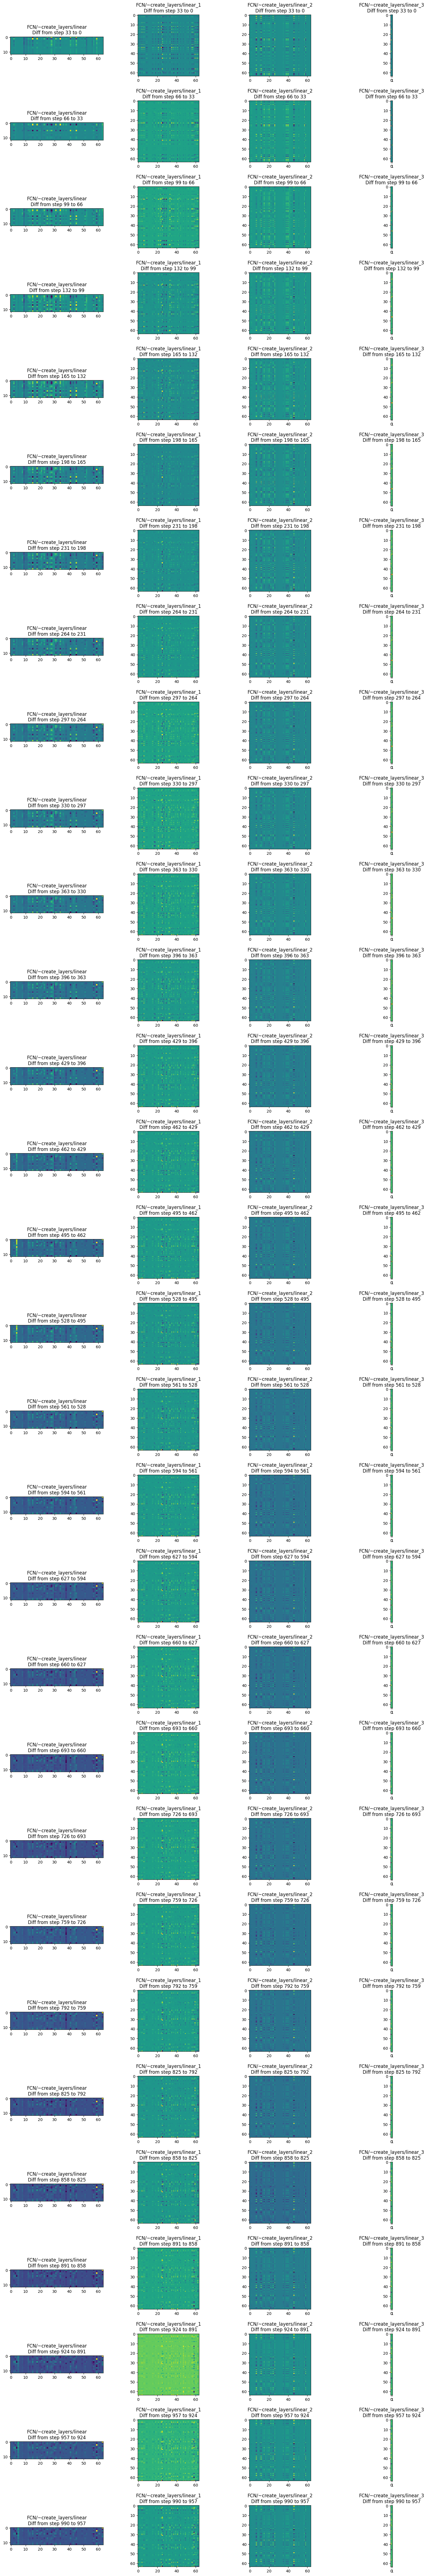

In [29]:

rows = len(saves_loaded.keys())
cols = len(p)
fig = plt.figure(figsize=(5*cols, 4*rows))
fig.subplots_adjust(hspace=0.4)
i = 0
diff_min = 0
diff_max = 0
for k0, k1 in zip(list(saves_loaded.keys())[:-1], list(saves_loaded.keys())[1:]):
    p0 = saves_loaded[k0]['params']
    p0 = arrayise(p0)
    p = saves_loaded[k1]['params']
    p = arrayise(p)

    for k, v0, v in zip(p0.keys(), p0.values(), p.values()):
        diff = v['w'] - v0['w']
        diff_min = np.min([diff_min, diff.min()])
        diff_max = np.max([diff_max, diff.max()])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(diff)
        # plt.imshow(v['w'])
        # plt.clim(diff_min, diff_max)
        i += 1
        plt.title(f'{k}\nDiff from step {k1} to {k0}')

### TSNE


In [30]:
step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

pred_y = model.apply(p, rng, x_val)

In [31]:
x_og_val = xscaler.inverse_transform(x_val)

try:
    cols = list(map(str, np.arange(x.shape[-1])))
    df1 = pd.DataFrame(data=x_og_val, columns=cols)
    # df1['image'] = df1.apply(lambda row: wandb.Image(row.values.reshape(1, x_og_val.shape[-1])), axis=1)
    if USE_CATEGORICAL:
        df1['Predicted Sensitivity'] = np.argmax(pred_y, axis=1)
    else:
        df1['Predicted Sensitivity'] = pred_y[:, 0]
        df1['Predicted Sensitivity ratio from mutation to base'] = pred_y[:, 1]
    df1['Actual Sensitivity'] = y_val[:, 0]
    df1['Actual Sensitivity ratio from mutation to base'] = y_val[:, 1]
    df1['interacting'] = [str(np.round(i, 2)) for i in list(x_og_val[:, :6])]
    df1['interacting diffs'] = [str(np.round(i, 2)) for i in list(x_og_val[:, 6:])]
    df1['zeros_idxs'] = [''.join([str(ii) for ii in np.argwhere(
        i == 0).tolist()]).replace('[', '').replace(']', '') for i in list(x_og_val[:, :6])]
    # df1['target'] = df1['target'].apply(str)
    # df1 = df1[df1.columns.tolist()[-2:] + df1.columns.tolist()[:-2]]

    wandb.log({"digits": df1})
except:
    print('nah')
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run helpful-elevator-48 at: https://wandb.ai/steel-lab/mlp-encoder_decoder/runs/toc0r1qc
wandb: Synced 5 W&B file(s), 1 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231027_175514-toc0r1qc/logs
